# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Customization Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns",100)
# plt.style.use(['fivethirtyeight','seaborn-talk'])
# mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

SEED = 321
np.random.seed(SEED)
from sklearn.base import clone

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

# Loading Saved Joblib File

In [3]:
loaded_joblib = joblib.load('salespredictions.joblib')
loaded_joblib.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForestRegression', 'LinearRegression'])

In [4]:
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
y_test = loaded_joblib['y_test']
X_test = loaded_joblib['X_test']
preprocessor = loaded_joblib['preprocessor']
rf = loaded_joblib['RandomForestRegression']
lr = loaded_joblib['LinearRegression']

In [5]:
## let's check X_train
X_train.head()

Item_Weight Item_Fat_Content  Item_Visibility     Item_Type  Item_MRP  \
4776       16.350          Low Fat         0.029565     Household  256.4646   
7510       15.250          Regular         0.000000   Snack Foods  179.7660   
5828       12.350          Regular         0.158716          Meat  157.2946   
5327        7.975          Low Fat         0.014628  Baking Goods   82.3250   
4810       19.350          Low Fat         0.016645  Frozen Foods  120.9098   

      Outlet_Size Outlet_Location_Type        Outlet_Type  
4776          1.0               Tier 3  Supermarket Type2  
7510          1.0               Tier 3  Supermarket Type2  
5828          1.0               Tier 1  Supermarket Type1  
5327          0.0               Tier 2  Supermarket Type1  
4810          NaN               Tier 2  Supermarket Type1

In [6]:
## Get feature names from already-fit preprocessor

feature_names = preprocessor.get_feature_names_out()

## Use the preprocessor to transform X_train into X_train_df
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)


## Use the preprocessor to transform X_test into X_test_df 

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Size  \
4776     0.817249        -0.712775  1.828109     0.407785   
7510     0.556340        -1.291052  0.603369     0.407785   
5828    -0.131512         1.813319  0.244541     0.407785   
5327    -1.169219        -1.004931 -0.952591    -1.291630   
4810     1.528819        -0.965484 -0.336460     0.000000   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
4776                       0.0                     0.0               0.0   
7510                       1.0                     0.0               0.0   
5828                       1.0                     0.0               0.0   
5327                       0.0                     1.0               0.0   
4810                       0.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
4776                  0.0               0.0              0.0   
7510                  0.0               0.0              0.0   
5828                  0.0               0.0              0.0   
5327                  0.0               0.0              0.0   
4810                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
4776                     0.0                              0.0   
7510                     0.0                              0.0   
5828                     0.0                              0.0   
5327                     0.0                              0.0   
4810                     1.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
4776                    0.0                           0.0   
7510                    0.0                           0.0   
5828                    0.0                           0.0   
5327                    0.0                           0.0   
4810                    0.0                           0.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Seafood  \
4776                  1.0             0.0                0.0   
7510                  0.0             0.0                0.0   
5828                  0.0             1.0                0.0   
5327                  0.0             0.0                0.0   
4810                  0.0             0.0                0.0   

      Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
4776                    0.0                    0.0                      0.0   
7510                    1.0                    0.0                      0.0   
5828                    0.0                    0.0                      0.0   
5327                    0.0                    0.0                      0.0   
4810                    0.0                    0.0                      0.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
4776                          0.0                          0.0   
7510                          0.0                          0.0   
5828                          1.0                          0.0   
5327                          0.0                          1.0   
4810                          0.0                          1.0   

      Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
4776                        0.0                            0.0   
7510                        0.0                            0.0   
5828                        0.0                            1.0   
5327                        0.0                            1.0   
4810                        0.0                            1.0   

      Outlet_Type_Supermarket Type2  
4776                            1.0  
7510                            1.0  
5828                            0.0  
5327                            0.0  
4810                            0.0

# Explain your tree-based model with shap:


In [7]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [8]:
X_shap = shap.sample(X_test,random_state=321)
X_shap

Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
6304       17.700          Low Fat         0.116724            Snack Foods   
2164          NaN          Regular         0.045867           Frozen Foods   
7870       11.100          Regular         0.053731  Fruits and Vegetables   
5840        6.635          Regular         0.006352           Baking Goods   
6000          NaN          Low Fat         0.021273              Breakfast   
...           ...              ...              ...                    ...   
2748        8.395          Low Fat         0.039485            Snack Foods   
6862       19.600          Low Fat         0.056744            Soft Drinks   
538        16.600          Low Fat         0.026537           Frozen Foods   
540        19.700          Low Fat         0.089084  Fruits and Vegetables   
7223       15.700          Low Fat         0.037201            Soft Drinks   

      Item_MRP  Outlet_Size Outlet_Location_Type        Outlet_Type  
6304  182.4266          1.0               Tier 1  Supermarket Type1  
2164   37.9506          1.0               Tier 3  Supermarket Type3  
7870  165.1526          2.0               Tier 3  Supermarket Type1  
5840  120.3098          1.0               Tier 3  Supermarket Type2  
6000  229.1326          1.0               Tier 3  Supermarket Type3  
...        ...          ...                  ...                ...  
2748   97.9042          0.0               Tier 2  Supermarket Type1  
6862   55.6614          NaN               Tier 3      Grocery Store  
538    57.2614          0.0               Tier 1  Supermarket Type1  
540    54.5930          NaN               Tier 3      Grocery Store  
7223  181.7634          2.0               Tier 3  Supermarket Type1  

[100 rows x 8 columns]

In [9]:
## get the corresponding y-values
y_shap = y_test.loc[X_shap.index]
y_shap 

6304    5163.9448
2164     910.8144
7870    1480.0734
5840    1446.1176
6000    7393.0432
          ...    
2748    1686.4714
6862     165.7842
538     1049.9666
540       56.5930
7223    2544.6876
Name: Item_Outlet_Sales, Length: 100, dtype: float64

In [10]:
## Setting float format for readability
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

In [11]:
## Get the coefficients from the lin reg
coeffs = get_coefficients(lr)
coeffs

Item_Weight                           -7.39
Item_Visibility                      -21.67
Item_MRP                             984.39
Outlet_Size                            1.07
Item_Fat_Content_Regular              63.11
Item_Type_Baking Goods                31.74
Item_Type_Breads                       1.95
Item_Type_Breakfast                   78.60
Item_Type_Canned                      57.82
Item_Type_Dairy                      -74.33
Item_Type_Frozen Foods                29.52
Item_Type_Fruits and Vegetables       75.12
Item_Type_Hard Drinks                 41.74
Item_Type_Health and Hygiene          58.19
Item_Type_Household                   35.01
Item_Type_Meat                        22.20
Item_Type_Seafood                    350.05
Item_Type_Snack Foods                 10.99
Item_Type_Soft Drinks                -10.46
Item_Type_Starchy Foods               76.57
Outlet_Location_Type_Tier 1          -11.20
Outlet_Location_Type_Tier 2           -6.44
Outlet_Type_Grocery Store       

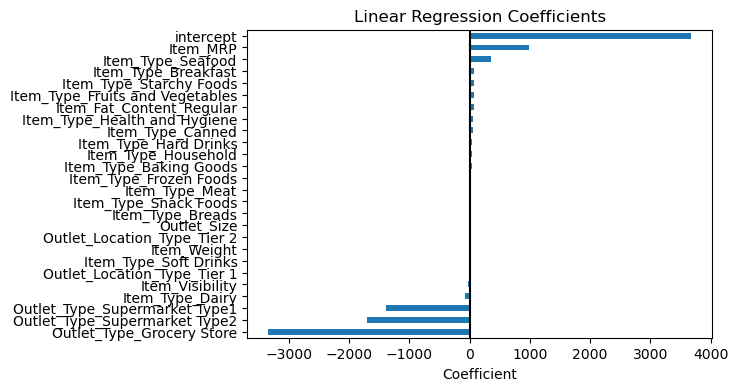

<AxesSubplot: title={'center': 'Linear Regression Coefficients'}, xlabel='Coefficient'>

In [12]:
## plot the coefficients
plot_coefficients(coeffs)

# Random Forest

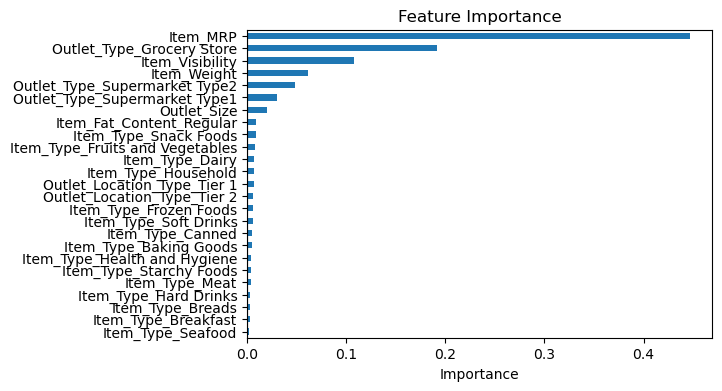

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [13]:
## evaluate the random forest
evaluate_regression(rf,X_train_df,y_train, X_test_df, y_test)

## extract the plot the feature importances
importances = get_importances(rf)
plot_importances(importances)

In [14]:
from sklearn.inspection import permutation_importance

In [15]:
## run performatation_importance on the rf  using the test data and random_state=SEED
result = permutation_importance(rf, X_test_df, y_test,scoring='r2',
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [16]:
## save the average importances as a Series
perm_importances = pd.Series(result['importances_mean'], index=rf.feature_names_in_)
perm_importances

Item_Weight                       -0.02
Item_Visibility                   -0.01
Item_MRP                           0.72
Outlet_Size                        0.00
Item_Fat_Content_Regular          -0.01
Item_Type_Baking Goods             0.00
Item_Type_Breads                  -0.00
Item_Type_Breakfast               -0.00
Item_Type_Canned                  -0.00
Item_Type_Dairy                   -0.01
Item_Type_Frozen Foods            -0.00
Item_Type_Fruits and Vegetables   -0.00
Item_Type_Hard Drinks             -0.00
Item_Type_Health and Hygiene      -0.00
Item_Type_Household               -0.00
Item_Type_Meat                    -0.00
Item_Type_Seafood                  0.00
Item_Type_Snack Foods             -0.00
Item_Type_Soft Drinks             -0.00
Item_Type_Starchy Foods           -0.00
Outlet_Location_Type_Tier 1       -0.00
Outlet_Location_Type_Tier 2       -0.00
Outlet_Type_Grocery Store          0.71
Outlet_Type_Supermarket Type1      0.21
Outlet_Type_Supermarket Type2      0.12


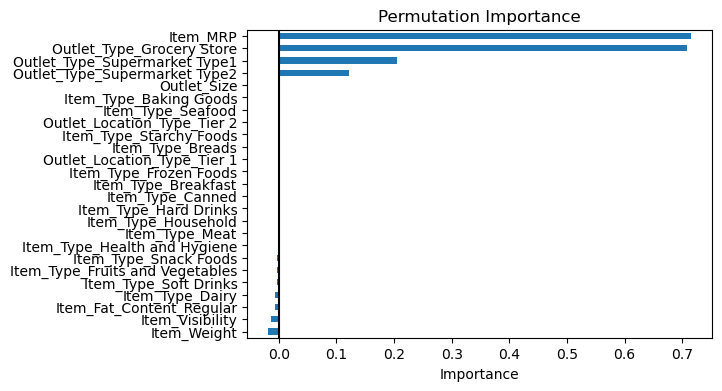

<AxesSubplot: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [17]:
# Use our plot_importances function, but change title to "Permutation Importance"
plot_importances(perm_importances,title='Permutation Importance')

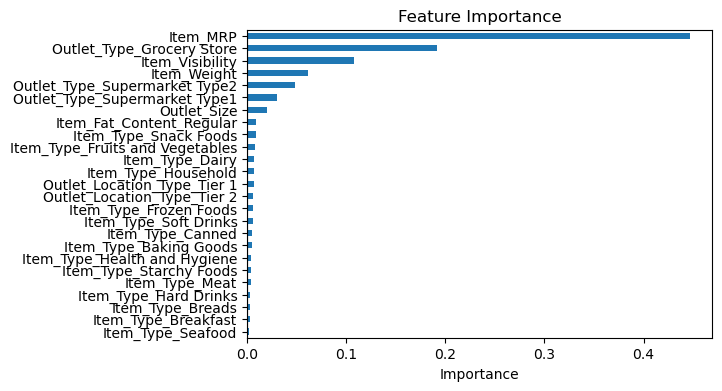

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [18]:
# Compare to the random forst feature importance
plot_importances(importances)

# LinearRegression Permutation Importance

In [19]:
## run performatation_importance on the lin_reg  using the test data and random_state=SEED
results_linreg = permutation_importance(lr, X_test_df, y_test,scoring='r2', n_repeats=3,
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

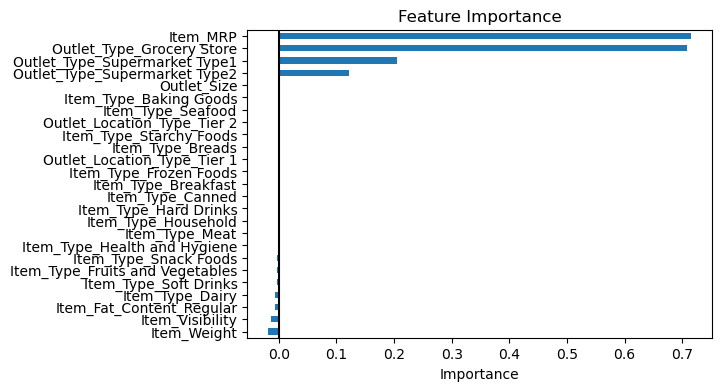

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [20]:
## Make into a series called perm_importances_linreg
perm_importances_linreg = pd.Series(result['importances_mean'], 
                                    index=lr.feature_names_in_)

plot_importances(perm_importances_linreg)

In [21]:
# Import and init shap
import shap
shap.initjs()

In [22]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train_df,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Size  \
3888         0.70             0.87     -1.68         0.00   
2497         0.52             0.42      1.28        -1.29   
7723         1.09            -0.99      0.68         0.00   
8117        -0.50            -0.32      1.62         0.00   
7475         0.50            -0.41     -0.02         0.00   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
3888                      1.00                    0.00              0.00   
2497                      1.00                    0.00              0.00   
7723                      0.00                    0.00              0.00   
8117                      0.00                    0.00              0.00   
7475                      0.00                    0.00              0.00   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
3888                 0.00              0.00             0.00   
2497                 0.00              0.00             0.00   
7723                 0.00              0.00             0.00   
8117                 0.00              0.00             0.00   
7475                 0.00              0.00             0.00   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
3888                    1.00                             0.00   
2497                    0.00                             1.00   
7723                    0.00                             1.00   
8117                    0.00                             1.00   
7475                    0.00                             0.00   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
3888                   0.00                          0.00   
2497                   0.00                          0.00   
7723                   0.00                          0.00   
8117                   0.00                          0.00   
7475                   0.00                          1.00   

      Item_Type_Household  Item_Type_Meat  Item_Type_Seafood  \
3888                 0.00            0.00               0.00   
2497                 0.00            0.00               0.00   
7723                 0.00            0.00               0.00   
8117                 0.00            0.00               0.00   
7475                 0.00            0.00               0.00   

      Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
3888                   0.00                   0.00                     0.00   
2497                   0.00                   0.00                     0.00   
7723                   0.00                   0.00                     0.00   
8117                   0.00                   0.00                     0.00   
7475                   0.00                   0.00                     0.00   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
3888                         0.00                         1.00   
2497                         1.00                         0.00   
7723                         0.00                         1.00   
8117                         0.00                         1.00   
7475                         0.00                         1.00   

      Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
3888                       0.00                           1.00   
2497                       0.00                           1.00   
7723                       0.00                           1.00   
8117                       0.00                           1.00   
7475                       0.00                           1.00   

      Outlet_Type_Supermarket Type2  
3888                           0.00  
2497                           0.00  
7723                           0.00  
8117                           0.00  
7475                           0.00

In [23]:
# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf)

## Get shap values from the explainer
shap_values = explainer(X_shap,y_shap)

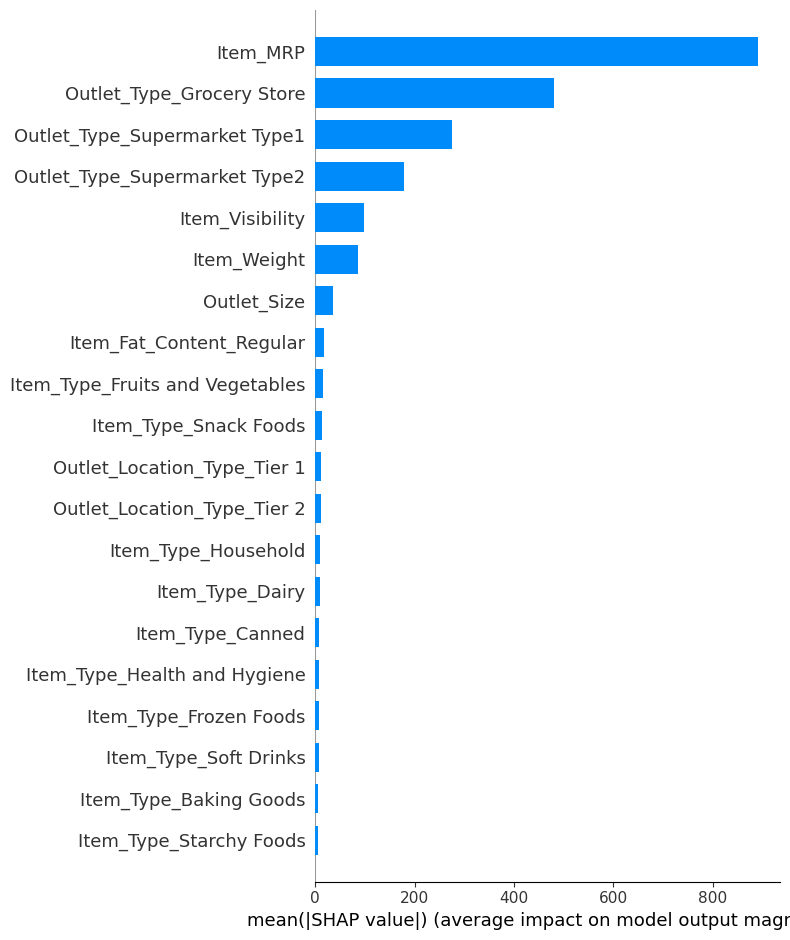

In [24]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


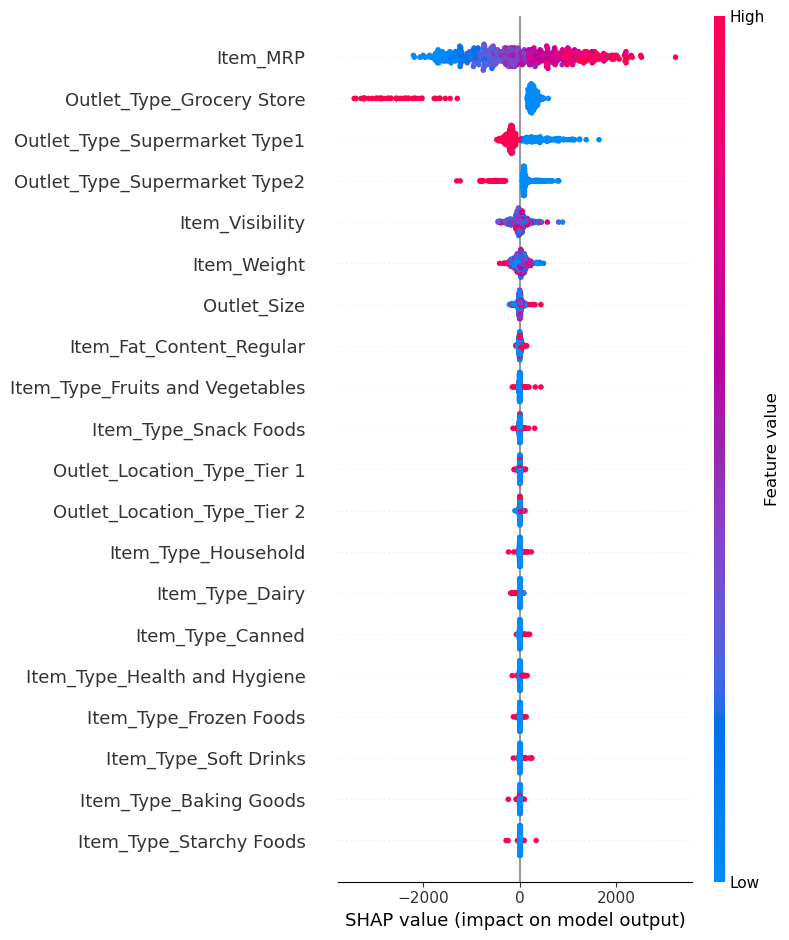

In [25]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)

# Summary Plot - Dot Explanation
* The figure above is a dot summary of the important features of the data set. The three most important features are ItemMRP, Outlet Type Grocery Store, and Outlet Type Supermarket Type 1. 
* For Item MRP, we see the red dots are on the right or positive side, we can see that the higher the Item MRP, the more likely the model will predict a higher sale. 
* For Outlet Type Grocerstore, we see the red values are on the left or negative side, and since this feature is OHE or a yes or no, this means that if a store is a Grocery Store then the model is likely to predict less sales. 
* For Outlet Type Supermarket Type 1, the red vaues are on the left, meaning if the store is of type Outlet Type Supermarket Type 1, then the model predicts a lower sale. 

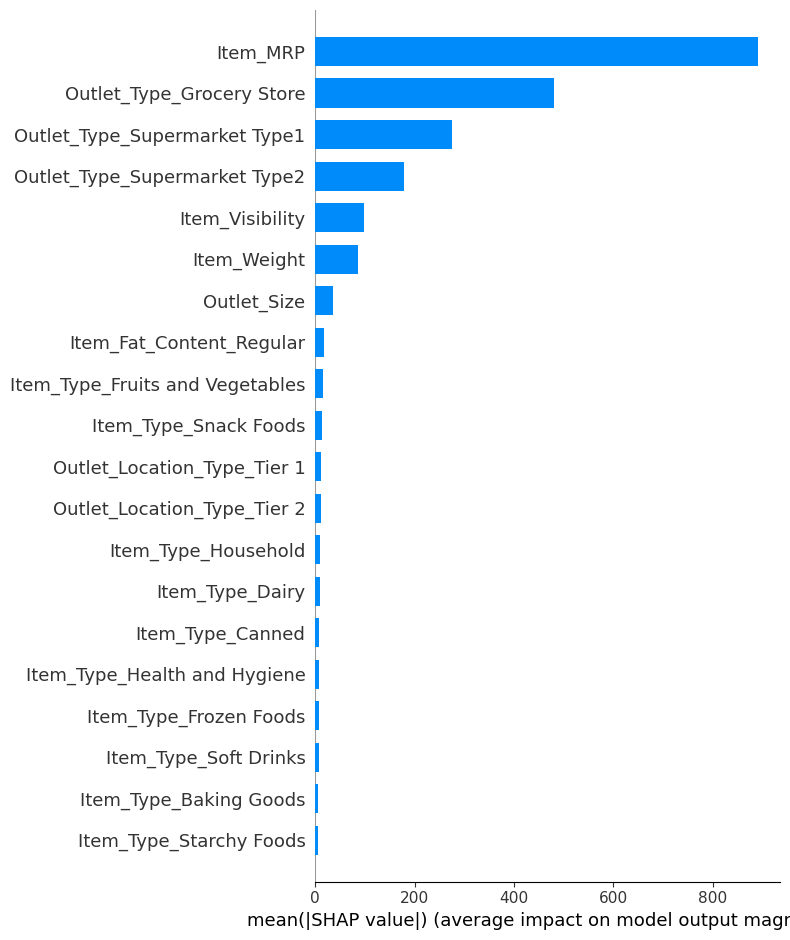

In [26]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

# Summary Plot - Bar Explanation
* The figure above is a shap summary of importances while the figure below shows the importances from a random forest model without SHAP. We see that for both models, the most important feature is ItemMRP and following that for both figures in importance is Outlet Type Grocercy Store. Where it starts to differ are the next 5 features after the first two important features. We see that Outlet Type Supermarket Type 1 and Outlet Type Supermarket Type 2 are replaced in order of importance by Item Visibilty and Item Weight for both figures respectively. This does make sense becuase the random forest importance figure below, the model did not take into account permutation importance. In summary, the top two most important features are ItemMRP and Outlet Type Grocery Store. 

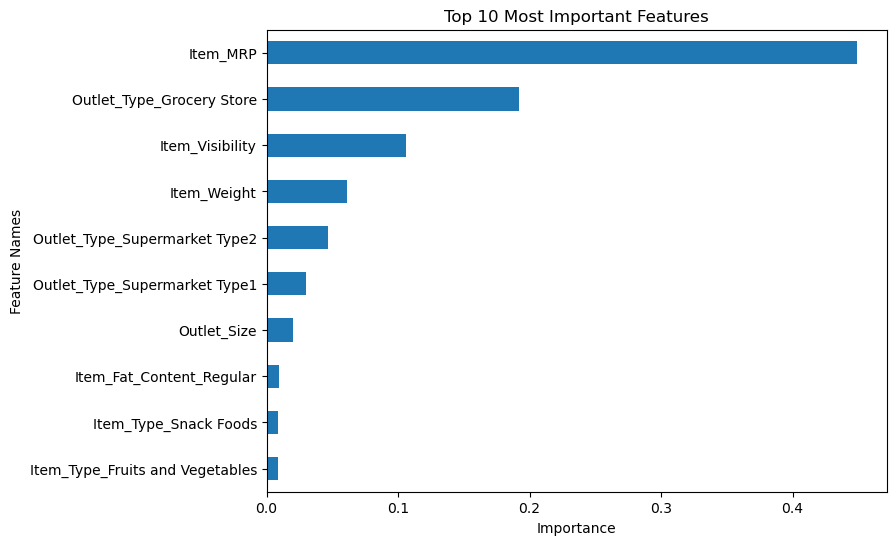


# Local Explanations

In [27]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Size  \
0         0.70             0.87     -1.68         0.00   
1         0.52             0.42      1.28        -1.29   
2         1.09            -0.99      0.68         0.00   
3        -0.50            -0.32      1.62         0.00   
4         0.50            -0.41     -0.02         0.00   

   Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
0                      1.00                    0.00              0.00   
1                      1.00                    0.00              0.00   
2                      0.00                    0.00              0.00   
3                      0.00                    0.00              0.00   
4                      0.00                    0.00              0.00   

   Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
0                 0.00              0.00             0.00   
1                 0.00              0.00             0.00   
2                 0.00              0.00             0.00   
3                 0.00              0.00             0.00   
4                 0.00              0.00             0.00   

   Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
0                    1.00                             0.00   
1                    0.00                             1.00   
2                    0.00                             1.00   
3                    0.00                             1.00   
4                    0.00                             0.00   

   Item_Type_Hard Drinks  Item_Type_Health and Hygiene  Item_Type_Household  \
0                   0.00                          0.00                 0.00   
1                   0.00                          0.00                 0.00   
2                   0.00                          0.00                 0.00   
3                   0.00                          0.00                 0.00   
4                   0.00                          1.00                 0.00   

   Item_Type_Meat  Item_Type_Seafood  Item_Type_Snack Foods  \
0            0.00               0.00                   0.00   
1            0.00               0.00                   0.00   
2            0.00               0.00                   0.00   
3            0.00               0.00                   0.00   
4            0.00               0.00                   0.00   

   Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
0                   0.00                     0.00   
1                   0.00                     0.00   
2                   0.00                     0.00   
3                   0.00                     0.00   
4                   0.00                     0.00   

   Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                         0.00                         1.00   
1                         1.00                         0.00   
2                         0.00                         1.00   
3                         0.00                         1.00   
4                         0.00                         1.00   

   Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
0                       0.00                           1.00   
1                       0.00                           1.00   
2                       0.00                           1.00   
3                       0.00                           1.00   
4                       0.00                           1.00   

   Outlet_Type_Supermarket Type2  
0                           0.00  
1                           0.00  
2                           0.00  
3                           0.00  
4                           0.00

In [28]:
# what is the max/range of infant deaths
X_shap_local['Item_MRP'].describe()

count   500.00
mean      0.05
std       1.01
min      -1.76
25%      -0.70
50%       0.03
75%       0.78
max       1.97
Name: Item_MRP, dtype: float64

# Examples explanation
* The two local example we will explain are the highest and lowest values for Item MRP. We chose these examples to highlight how important and impactful Item MRP is Item Outlet Sales, which is our target. We specifically chose Item MRP because it had the most importance in predictions, as shown in the global explanation figures earlier. 

# Highest Item MRP

In [29]:
idx_high_MRP = X_shap_local['Item_MRP'].idxmax()
idx_high_MRP

171

In [30]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_MRP]

Item_Weight                       -0.69
Item_Visibility                   -0.78
Item_MRP                           1.97
Outlet_Size                        0.00
Item_Fat_Content_Regular           0.00
Item_Type_Baking Goods             0.00
Item_Type_Breads                   0.00
Item_Type_Breakfast                0.00
Item_Type_Canned                   1.00
Item_Type_Dairy                    0.00
Item_Type_Frozen Foods             0.00
Item_Type_Fruits and Vegetables    0.00
Item_Type_Hard Drinks              0.00
Item_Type_Health and Hygiene       0.00
Item_Type_Household                0.00
Item_Type_Meat                     0.00
Item_Type_Seafood                  0.00
Item_Type_Snack Foods              0.00
Item_Type_Soft Drinks              0.00
Item_Type_Starchy Foods            0.00
Outlet_Location_Type_Tier 1        0.00
Outlet_Location_Type_Tier 2        1.00
Outlet_Type_Grocery Store          0.00
Outlet_Type_Supermarket Type1      1.00
Outlet_Type_Supermarket Type2      0.00


In [31]:
## what was the actual sale
y_shap_local.iloc[idx_high_MRP]

5815.0972

In [32]:
## plotting example force plot for most inf.deaths (from rf)
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_high_MRP].values,
               features=X_shap_local.iloc[idx_high_MRP])

In [33]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [34]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_MRP],
                                      rf.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


# Highest MRP Summary
* From the figure above in the LIME explanation, we see that the feature that most heavily influenced the predictions were Outlet Type Grocery, Item MRP, and Outlet Type Supermarket Type 1. Outlet Type Grocery and Item MRP had the most positive influence in predicting higher sales, while Outlet Type Supermarket Type 1 had the biggest influence in lowers the predicted sales. The biggest influential feature was Outlet Type Grocery. We also see that the predicted value for sale was only off by 629  dollars. 

* From the force plot figure, we see that the features that had the most impact in increasing the predicted sales were Item MRP, Outlet Type Grocery Store, and Item Visibility. The most influential feature for the force plot was Item MRP. We also see that the predicted value for sale was only off by 629 dollars. 


# Lowest Item MRP

In [35]:
idx_low_MRP = X_shap_local['Item_MRP'].idxmin()
idx_low_MRP

6

In [36]:
# checking the feature values for selected example
X_shap_local.iloc[idx_low_MRP]

Item_Weight                        0.76
Item_Visibility                    1.83
Item_MRP                          -1.76
Outlet_Size                       -1.29
Item_Fat_Content_Regular           1.00
Item_Type_Baking Goods             0.00
Item_Type_Breads                   0.00
Item_Type_Breakfast                0.00
Item_Type_Canned                   0.00
Item_Type_Dairy                    0.00
Item_Type_Frozen Foods             1.00
Item_Type_Fruits and Vegetables    0.00
Item_Type_Hard Drinks              0.00
Item_Type_Health and Hygiene       0.00
Item_Type_Household                0.00
Item_Type_Meat                     0.00
Item_Type_Seafood                  0.00
Item_Type_Snack Foods              0.00
Item_Type_Soft Drinks              0.00
Item_Type_Starchy Foods            0.00
Outlet_Location_Type_Tier 1        0.00
Outlet_Location_Type_Tier 2        1.00
Outlet_Type_Grocery Store          0.00
Outlet_Type_Supermarket Type1      1.00
Outlet_Type_Supermarket Type2      0.00


In [37]:
## what was the actual sale
y_shap_local.iloc[idx_low_MRP]

1018.674

In [38]:
## plotting example force plot for most inf.deaths (from rf)
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_low_MRP].values,
               features=X_shap_local.iloc[idx_low_MRP])

In [39]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_low_MRP],
                                      rf.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


# Lowest MRP Summary
* From the figure above in the LIME explanation, we see that the feature that most heavily influenced the predictions were Outlet Type Grocery, Item MRP, and Outlet Type Supermarket Type 1. Outlet Type Grocery and Outlet Type Supermarket Type 2 had the most positive influence in predicting higher sales, while Outlet Type Supermarket Type 1 and Item MRP had the biggest influence in lowering the predicted sales. The biggest influential feature was Outlet Type Grocery Store and right after it was Item MRP. We also see that the predicted value for sale was only off by 189  dollars. 

* From the force plot figure, we see that the features that had the most impact in increasing the predicted sales was Outlet Type Grocery Store. The most influential feature for the force plot was Item MRP. We see that Item MRP had the biggest influence in predicting a lower sale.  We also see that the predicted value for sale was only off by 189 dollars. 